##### ***IMPORT LIBRARY***

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

##### ***DATA AUGMENTATION & LOADING***

In [45]:
# Augmentasi gambar
def augment_image(img):
  """
  Augmentasi gambar untuk memperbanyak data
  """
  augmented = [img]

  # Horizontal flip
  augmented.append(img.transpose(Image.FLIP_LEFT_RIGHT))

  # Brightness variations
  enhancer = ImageEnhance.Brightness(img)
  augmented.append(enhancer.enhance(0.9)) # Darker
  augmented.append(enhancer.enhance(1.1)) # Brighter

  # Contrast variations
  enhancer = ImageEnhance.Contrast(img)
  augmented.append(enhancer.enhance(0.9))
  augmented.append(enhancer.enhance(1.1))

  return augmented

def load_images_with_augmentation(folder_path, label, target_size=(64, 64), augment=True):
  """
  Load gambar dengan augmentation
  """
  images = []
  labels = []
  filenames = []

  files = sorted(os.listdir(folder_path))

  for filename in files:
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
      try:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(target_size)

        if augment:
          # Augmentasi
          augmented_imgs = augment_image(img)
          for aug_img in augmented_imgs:
            img_array = np.array(aug_img).flatten()
            images.append(img_array)
            labels.append(label)
            filenames.append(f"{filename}_aug")
        else:
          # Original only
          img_array = np.array(img).flatten()
          images.append(img_array)
          labels.append(label)
          filenames.append(filename)

      except Exception as e:
        print(f"Error loading {filename}: {e}")

  return images, labels, filenames

# Path ke dataset
base_path = 'dataset'

print("--- MEMUAT DATA DENGAN AUGMENTASI ---")

# Load training data DENGAN augmentasi
cool_train, cool_labels_train, cool_files = load_images_with_augmentation(
  os.path.join(base_path, 'Cool'), label=0, augment=True
)
neutral_train, neutral_labels_train, neutral_files = load_images_with_augmentation(
  os.path.join(base_path, 'Neutral'), label=1, augment=True
)
warm_train, warm_labels_train, warm_files = load_images_with_augmentation(
  os.path.join(base_path, 'Warm'), label=2, augment=True
)

# Gabungkan semua data
X_full = np.array(cool_train + neutral_train + warm_train)
y_full = np.array(cool_labels_train + neutral_labels_train + warm_labels_train)

label_names = {0: 'Cool', 1: 'Neutral', 2: 'Warm'}

print(f"Data setelah augmentasi:")
print(f" Cool: {len(cool_train)}")
print(f" Neutral: {len(neutral_train)}")
print(f" Warm: {len(warm_train)}")
print(f" Total: {len(X_full)}")

--- MEMUAT DATA DENGAN AUGMENTASI ---
Data setelah augmentasi:
 Cool: 222
 Neutral: 318
 Warm: 318
 Total: 858


##### ***SPLIT DATA***

In [46]:
# Split data dengan pembagian 80:20
X_train, X_test, y_train, y_test = train_test_split(
  X_full, y_full,
  test_size=0.20,
  random_state=42,
  stratify=y_full
)

print("--- DATA SPLITTING ---")
print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

for i in range(3):
  train_count = (y_train == i).sum()
  test_count = (y_test == i).sum()
  print(f" {label_names[i]}: Train={train_count}, Test={test_count}")

--- DATA SPLITTING ---
Training: 686 samples
Testing: 172 samples
 Cool: Train=178, Test=44
 Neutral: Train=254, Test=64
 Warm: Train=254, Test=64


##### ***STANDARDISASI***

In [47]:
# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- STANDARDISASI ---")
print(f"Mean: {X_train_scaled.mean():.6f}")
print(f"Std: {X_train_scaled.std():.6f}")

--- STANDARDISASI ---
Mean: -0.000000
Std: 1.000000


##### ***PCA***

In [48]:
print("--- PCA - MENCARI KOMPONEN OPTIMAL ---")

# Test berbagai komponen
pca_options = [20, 30, 40, 50, 60, 70, 80]
best_pca_score = 0
best_n_comp = 0

for n_comp in pca_options:
  pca_temp = PCA(n_components=n_comp, random_state=42)
  X_train_pca_temp = pca_temp.fit_transform(X_train_scaled)
  
  # Quick test dengan KNN
  knn_temp = KNeighborsClassifier(n_neighbors=5, weights='distance')
  knn_temp.fit(X_train_pca_temp, y_train)
  
  # Cross-validation score
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  scores = []
  for train_idx, val_idx in cv.split(X_train_pca_temp, y_train):
    knn_temp.fit(X_train_pca_temp[train_idx], y_train[train_idx])
    score = knn_temp.score(X_train_pca_temp[val_idx], y_train[val_idx])
    scores.append(score)
  
  mean_score = np.mean(scores)
  variance = pca_temp.explained_variance_ratio_.sum()
  
  print(f"PCA={n_comp:2d} | Var={variance*100:.1f}% | CV Acc={mean_score*100:.2f}%")
  
  if mean_score > best_pca_score:
    best_pca_score = mean_score
    best_n_comp = n_comp

print(f"\n✓ Komponen optimal: {best_n_comp} (CV Acc: {best_pca_score*100:.2f}%)")

# Apply PCA dengan komponen optimal
pca = PCA(n_components=best_n_comp, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Varians terjaga: {pca.explained_variance_ratio_.sum()*100:.2f}%")

--- PCA - MENCARI KOMPONEN OPTIMAL ---


PCA=20 | Var=98.0% | CV Acc=69.38%
PCA=30 | Var=98.6% | CV Acc=69.97%
PCA=40 | Var=98.9% | CV Acc=71.13%
PCA=50 | Var=99.1% | CV Acc=71.43%
PCA=60 | Var=99.3% | CV Acc=71.28%
PCA=70 | Var=99.4% | CV Acc=71.28%
PCA=80 | Var=99.5% | CV Acc=71.43%

✓ Komponen optimal: 50 (CV Acc: 71.43%)
Varians terjaga: 99.14%


##### ***TRAINING KNN & PEMILIHAN K TERBAIK***

In [49]:
# Training KNN & Pemilihan K Terbaik
print("--- TRAINING KNN & PEMILIHAN K TERBAIK ---")

knn_results = {}
for k in [3, 5, 7, 9]:
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train_pca, y_train)
  y_pred = knn.predict(X_test_pca)
  acc = accuracy_score(y_test, y_pred)
  knn_results[k] = (knn, acc)
  print(f"KNN (K={k}): {acc*100:.2f}%")

# Pilih KNN terbaik
best_k = max(knn_results, key=lambda k: knn_results[k][1])
final_model, final_acc = knn_results[best_k]
final_pred = final_model.predict(X_test_pca)
model_name = f"KNN (K={best_k})"

print(f"MODEL TERPILIH: {model_name} (Akurasi: {final_acc*100:.2f}%)")

--- TRAINING KNN & PEMILIHAN K TERBAIK ---
KNN (K=3): 78.49%
KNN (K=5): 76.16%
KNN (K=7): 75.58%
KNN (K=9): 70.35%
MODEL TERPILIH: KNN (K=3) (Akurasi: 78.49%)


##### ***EVALUASI FINAL***

In [50]:
# Metrik Evaluasi
accuracy = accuracy_score(y_test, final_pred)
precision = precision_score(y_test, final_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, final_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, final_pred, average='weighted', zero_division=0)

print(f"\nMetrik Evaluasi:")
print(f" Akurasi : {accuracy*100:.2f}%")
print(f" Presisi : {precision*100:.2f}%")
print(f" Recall  : {recall*100:.2f}%")
print(f" F1-Score : {f1*100:.2f}%")

print(f"\n{'-'*60}")
print("CLASSIFICATION REPORT")
print(f"{'-'*60}")
y_test_names = [label_names[i] for i in y_test]
y_pred_names = [label_names[i] for i in final_pred]
print(classification_report(y_test_names, y_pred_names, digits=4))


Metrik Evaluasi:


 Akurasi : 78.49%
 Presisi : 78.60%
 Recall  : 78.49%
 F1-Score : 78.53%

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Cool     0.7174    0.7500    0.7333        44
     Neutral     0.7937    0.7812    0.7874        64
        Warm     0.8254    0.8125    0.8189        64

    accuracy                         0.7849       172
   macro avg     0.7788    0.7812    0.7799       172
weighted avg     0.7860    0.7849    0.7853       172



In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_pred)

print(f"\n{'-'*60}")
print("CONFUSION MATRIX")
print(f"{'-'*60}")
print(f"{'':12} {'Pred Cool':>12} {'Pred Neutral':>12} {'Pred Warm':>12}")
for i in range(3):
  print(f"True {label_names[i]:8} {cm[i][0]:12d} {cm[i][1]:12d} {cm[i][2]:12d}")

# Accuracy per class
print(f"\n{'-'*60}")
print("ACCURACY PER CLASS")
print(f"{'-'*60}")
for i in range(3):
  total = (y_test == i).sum()
  correct = cm[i][i]
  acc_class = correct / total if total > 0 else 0
  print(f"{label_names[i]:8}: {correct:2d}/{total:2d} = {acc_class*100:.2f}%")


------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------
                Pred Cool Pred Neutral    Pred Warm
True Cool               33            6            5
True Neutral             8           50            6
True Warm                5            7           52

------------------------------------------------------------
ACCURACY PER CLASS
------------------------------------------------------------
Cool    : 33/44 = 75.00%
Neutral : 50/64 = 78.12%
Warm    : 52/64 = 81.25%


##### ***VISUALISASI***

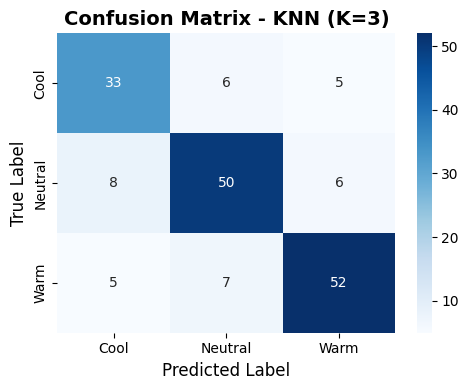

In [52]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
      xticklabels=['Cool', 'Neutral', 'Warm'],
      yticklabels=['Cool', 'Neutral', 'Warm'])
plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

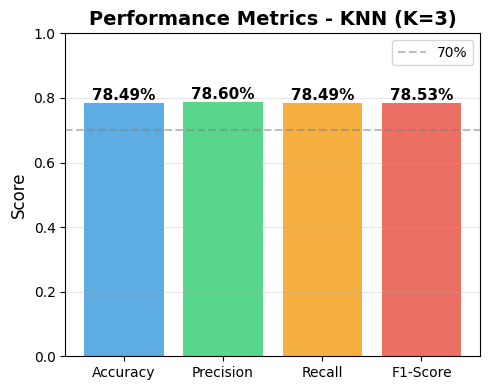

In [53]:
# Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(5, 4))
bars = plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8)
plt.ylim(0, 1.0)
plt.ylabel('Score', fontsize=12)
plt.title(f'Performance Metrics - {model_name}', fontsize=14, fontweight='bold')
plt.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='70%')

for bar, value in zip(bars, values):
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height,
      f'{value*100:.2f}%',
      ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

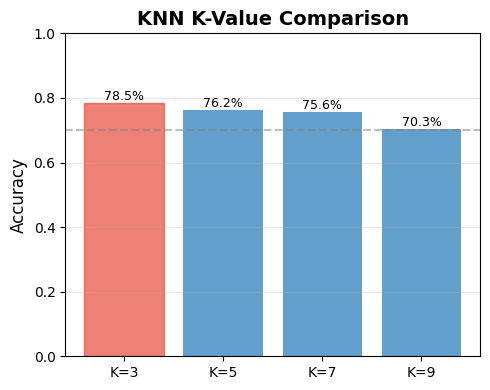

In [54]:
# Model Comparison (Hanya KNN K-values)
plt.figure(figsize=(5, 4))
knn_k_names = [f'K={k}' for k in knn_results.keys()]
knn_k_accs = [acc for _, acc in knn_results.values()]

bars = plt.bar(knn_k_names, knn_k_accs, alpha=0.7)
bars[list(knn_results.keys()).index(best_k)].set_color('#e74c3c') # Highlight best K
plt.ylabel('Accuracy', fontsize=12)
plt.title('KNN K-Value Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)

for bar, acc in zip(bars, knn_k_accs):
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height,
      f'{acc*100:.1f}%',
      ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

##### ***RINGKASAN HASIL***

In [55]:
# Ringkasan Hasil 
print("--- RINGKASAN HASIL PENELITIAN ---")
print(f"Dataset:")
print(f" Original: 143 gambar (Cool:37, Neutral:53, Warm:53)")
print(f" Augmented: {len(X_full)} gambar (6x augmentation)")
print(f" Image size: 64x64 RGB")
print(f" Features: {X_train.shape[1]:,}")
print(f"\nPreprocessing:")
print(f" Augmentation: Flip, Brightness, Contrast")
print(f" Train/Test: 80/20")
print(f" Standardization: Yes")
print(f"\nPCA:")
print(f" Components: {best_n_comp}")
print(f" Variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"\nModel:")
print(f" Type: {model_name}")
print(f" Akurasi: {accuracy*100:.2f}%")
print(f" Presisi: {precision*100:.2f}%")
print(f" Recall: {recall*100:.2f}%")
print(f" F1-Score: {f1*100:.2f}%")

--- RINGKASAN HASIL PENELITIAN ---
Dataset:
 Original: 143 gambar (Cool:37, Neutral:53, Warm:53)
 Augmented: 858 gambar (6x augmentation)
 Image size: 64x64 RGB
 Features: 12,288

Preprocessing:
 Augmentation: Flip, Brightness, Contrast
 Train/Test: 80/20
 Standardization: Yes

PCA:
 Components: 50
 Variance: 99.14%

Model:
 Type: KNN (K=3)
 Akurasi: 78.49%
 Presisi: 78.60%
 Recall: 78.49%
 F1-Score: 78.53%
